In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"latikadekate","key":"abebce29004ce12e7b8ac95365f86f94"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          13892        404  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1518         80  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           2624         86  1.0              
devansodariya/student-performance-data       

In [3]:
! kaggle datasets download -d jangedoo/utkface-new

 95% 315M/331M [00:03<00:00, 111MB/s]
100% 331M/331M [00:03<00:00, 108MB/s]


In [4]:
! unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [6]:
BASE_DIR = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/4_1_1...,4,1
1,/content/utkface_aligned_cropped/UTKFace/63_0_...,63,0
2,/content/utkface_aligned_cropped/UTKFace/53_0_...,53,0
3,/content/utkface_aligned_cropped/UTKFace/5_1_2...,5,1
4,/content/utkface_aligned_cropped/UTKFace/49_0_...,49,0


In [9]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

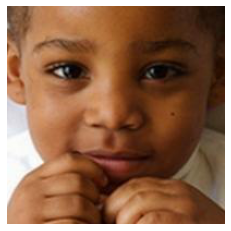

In [10]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

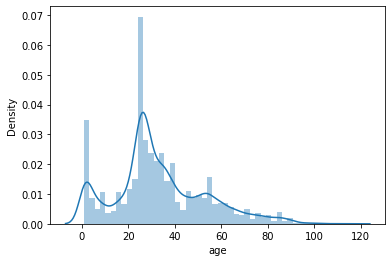

In [11]:
sns.distplot(df['age'])

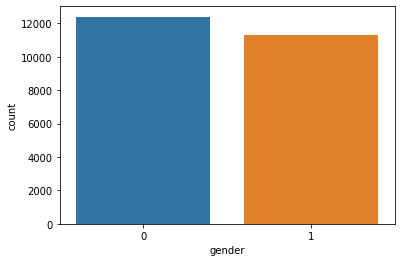

In [12]:
sns.countplot(df['gender'])


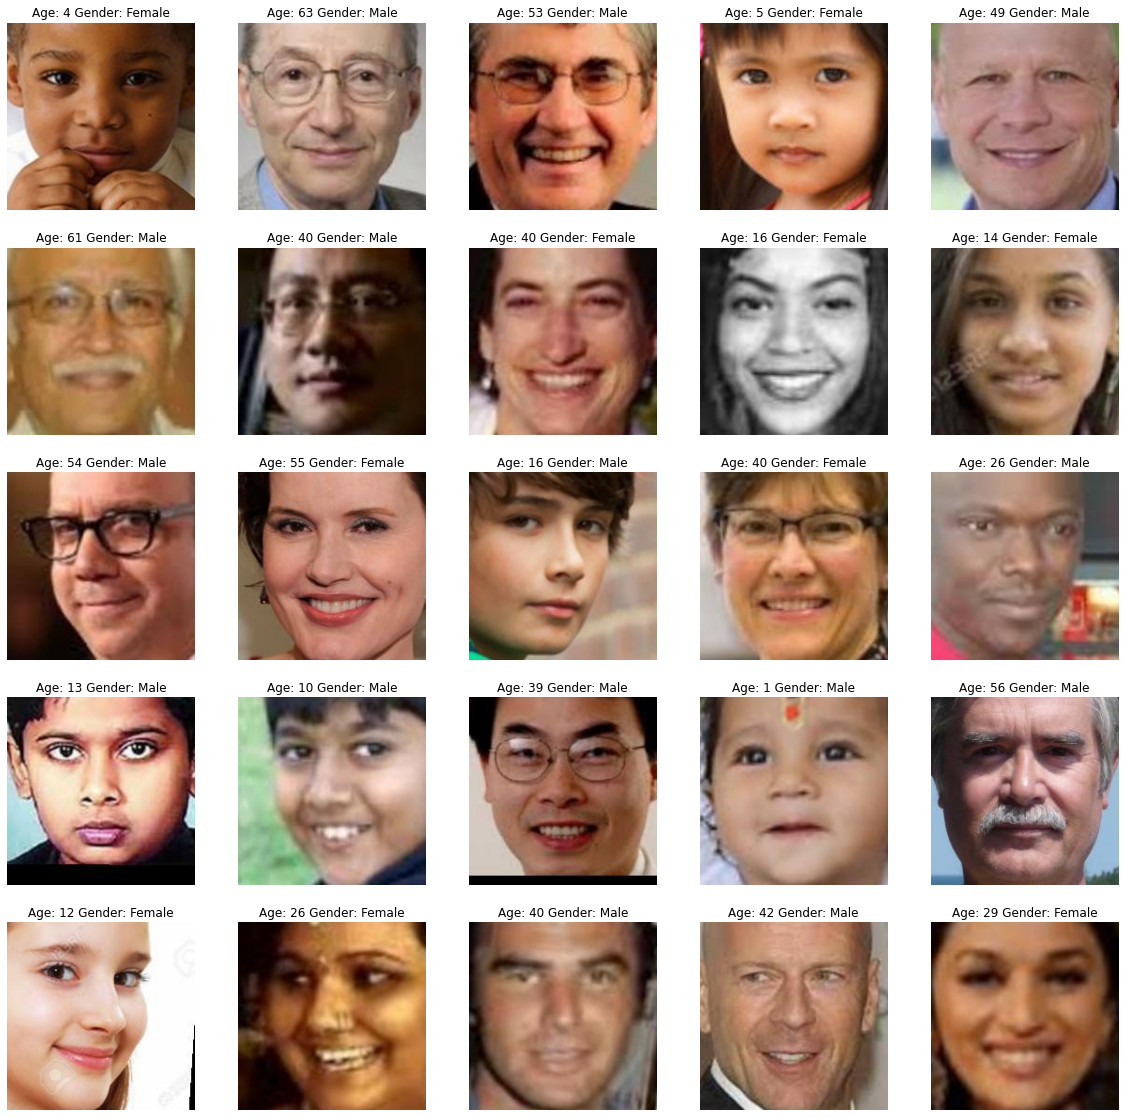

In [13]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [15]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [16]:
X.shape

(23708, 128, 128, 1)

In [17]:
# normalize the images
X = X/255.0

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [19]:
input_shape = (128, 128, 1)

In [20]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [21]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=10,  verbose=1, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 637s 1s/step - loss: 16.1665 - gender_out_loss: 0.6953 - age_out_loss: 15.4712 - gender_out_accuracy: 0.5203 - age_out_accuracy: 0.0462 - val_loss: 16.6136 - val_gender_out_loss: 0.6395 - val_age_out_loss: 15.9741 - val_gender_out_accuracy: 0.6531 - val_age_out_accuracy: 0.0460
Epoch 2/10
593/593 [==============================] - 634s 1s/step - loss: 12.4575 - gender_out_loss: 0.5473 - age_out_loss: 11.9102 - gender_out_accuracy: 0.7147 - age_out_accuracy: 0.0331 - val_loss: 11.0947 - val_gender_out_loss: 0.4562 - val_age_out_loss: 10.6384 - val_gender_out_accuracy: 0.7729 - val_age_out_accuracy: 0.0312
Epoch 3/10
593/593 [==============================] - 635s 1s/step - loss: 10.1336 - gender_out_loss: 0.4606 - age_out_loss: 9.6730 - gender_out_accuracy: 0.7811 - age_out_accuracy: 0.0153 - val_loss: 8.9558 - val_gender_out_loss: 0.4018 - val_age_out_loss: 8.5540 - val_gender_out_accuracy: 0.8003 - val_age_out_accuracy: 0.0164
Epoc

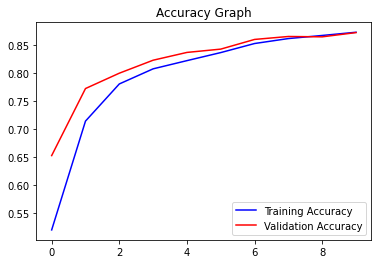

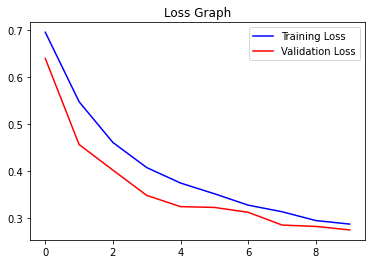

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

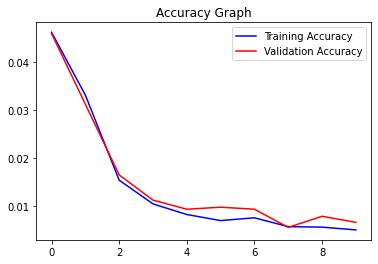

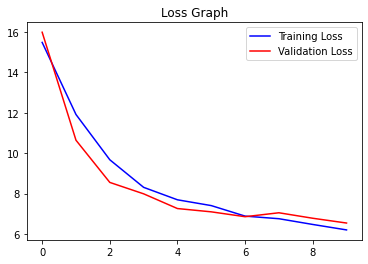

In [23]:
# plot results for age
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 34
Predicted Gender: Male Predicted Age: 37


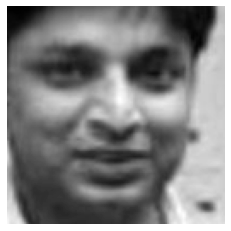

In [24]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 25
Predicted Gender: Female Predicted Age: 22


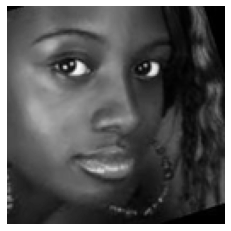

In [25]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 29
Predicted Gender: Male Predicted Age: 31


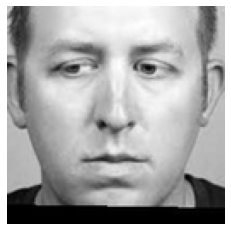

In [26]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');